# Seminar 5

## Plan

1. Posterior collapse
    1. VAE theory recall
    2. VAE on 2d data (examples from previous seminar)
    3. Posterior collapse
    4. How to fix it? (KL-annealing and Free-bits)

2. Normalizing flows
    1. Flows intro
        - Main idea
        - Change of Variable theorem
    2. Planar flow example
        - Matrix determinant lemma for planar flow.
        - Invertability
        - Forward and Backward KL

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import pickle
import os
import sys

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
    USE_CUDA = True
else:
    DEVICE='cpu'
    USE_CUDA = False

from typing import Optional, Tuple
from tqdm.notebook import tqdm

Loading `dgm_utils` for colab users

In [4]:
# REPO_NAME = "2023-DGM-MIPT-course"
# !if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
# !git clone https://github.com/r-isachenko/{REPO_NAME}.git
# !cd {REPO_NAME}
# !pip install ./{REPO_NAME}/homeworks/
# !rm -Rf {REPO_NAME}

Loading `dgm_utils` from local

In [5]:
import os, sys
DGM_UTILS_PATH = '../../homeworks'
sys.path.append(DGM_UTILS_PATH)

In [6]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_dataset

# VAE on 2D data

$
    L(\theta, \varphi) =
        \mathbb{E}_{q_{\varphi}(z | x)} \log p_{\theta} (x | z) -
        KL\{q_{\varphi} (z | x) || q(z)\}
$

**Q0** How VAE model is learning?

**Q1** How sampling from VAE works?

**Q2** Why do we need encoder? Why not just learn mapping from z to x?

**Q3** What if we throw away $KL\{q_{\varphi} (z | x) || q(z)\}$ term from ELBO?

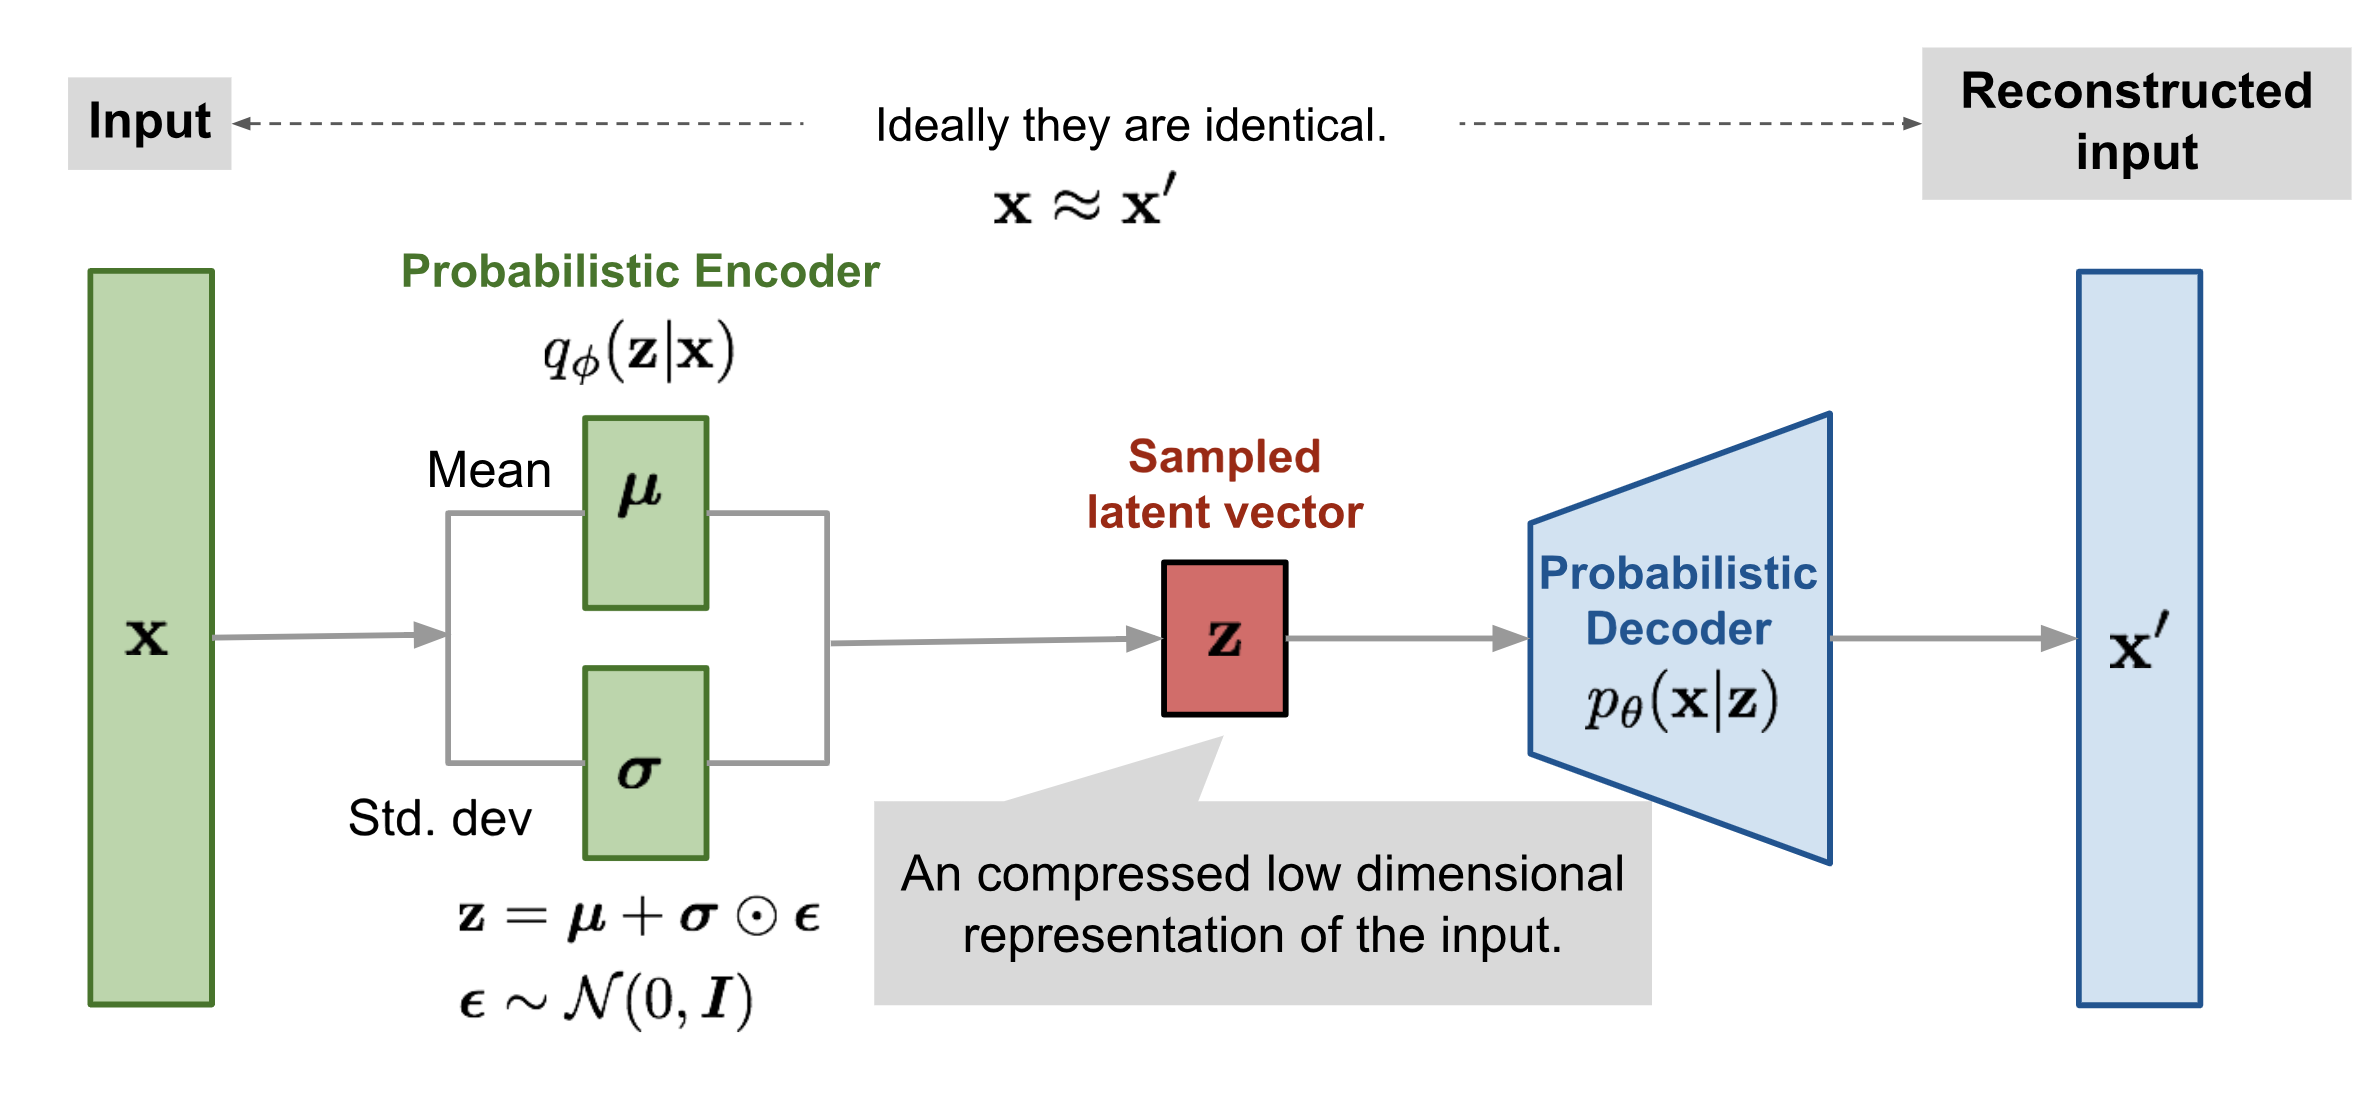

## Preparing data

In [7]:
def generate_2d_data(
    count: int, mode: str = "univariate"
) -> Tuple[np.ndarray, np.ndarray]:
    assert mode in ["univariate", "multivariate"]
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == "univariate":
        rotate = [[1.0, 0.0], [0.0, 1.0]]
    else:
        rotate = [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype("float32")
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

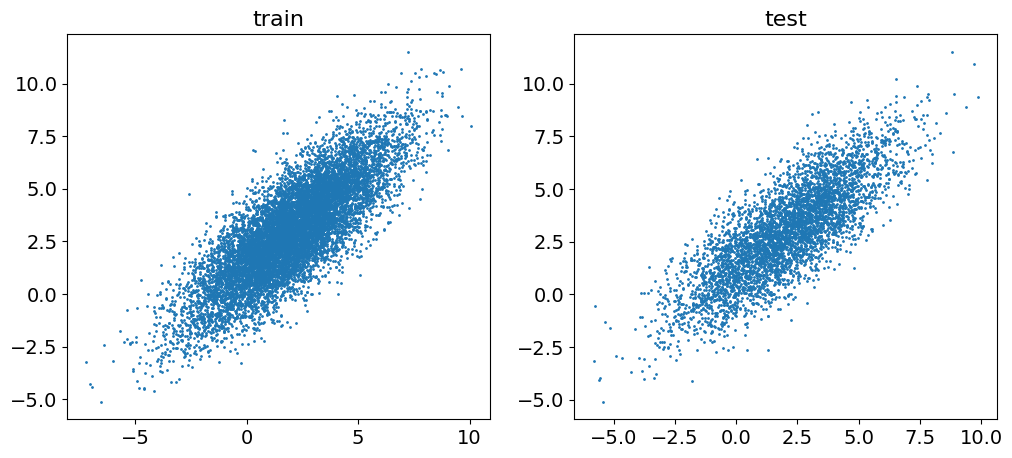

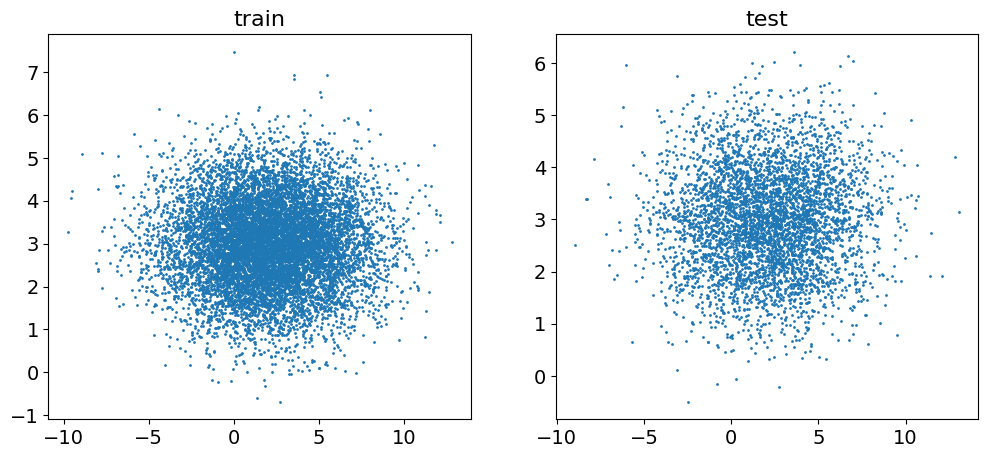

In [8]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

## VAE model

Utility functions for computing loss

In [9]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    # ====
    # your code
    return (
        (log_std_2 - log_std_1)
        + (torch.exp(log_std_1 * 2) + (mean_1 - mean_2) ** 2)
        / 2
        / torch.exp(log_std_2 * 2)
        - 0.5
    )
    # ====


def test_KL():
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)
        ).numpy(),
        200.2144,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)
        ).numpy(),
        1.50925,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_KL(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        [49.2990, 1498.479],
        rtol=1e-3,
    )


test_KL()

In [10]:
def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    # your code
    return (
        0.5 * np.log(2 * np.pi)
        + log_std
        + (x - mean) ** 2 * torch.exp(-2 * log_std) * 0.5
    )
    # ====


def test_NLL():
    assert np.isclose(
        get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(),
        3.9189,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(),
        6.9191,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_nll(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        np.array([3.9982, 5.9197]),
        rtol=1e-3,
    )


test_NLL()

MLP architecture for encoder and decoder

In [11]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape: int, hiddens: list, output_shape: int) -> None:
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []

        # ====
        # your code 
        # stack Dense layers with ReLU activation
        # note: you do not have to add relu after the last dense layer
        prev_h = input_shape
        for h in hiddens:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_shape))
        # ====
        self.net = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) ->  torch.Tensor:
        # ====
        # your code
        # apply network that was defined in __init__ and return the output
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, *self.output_shape)
        # ====

VAE model itself

In [12]:
class VAE2d(nn.Module):
    def __init__(
        self, n_in: int, n_latent: int, enc_hidden_sizes: list, dec_hidden_sizes: list, free_bits: float=None,
    ) -> None:
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent
        self.free_bits = torch.tensor(free_bits) if free_bits is not None else None

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        self.encoder = FullyConnectedMLP(n_in, enc_hidden_sizes, 2 * n_latent)
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in)
        # ====

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        return torch.randn(n, self.n_latent).cuda()
        # ====

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # now you have to return from the model
        # - mu_z - means for variational distribution
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint

        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        #    Note: [mu, log_std = decoder(input).chunk(2, dim=1)]

        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = self.prior(mu_z.shape[0]) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)
        # ====
        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x: torch.Tensor) -> dict:
        mu_z, log_std_z, mu_x, log_std_x = self(x)
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss using get_normal_nll (it is the first term in ELBO)
        # 3) compute KL loss using get_normal_KL (it is the second term in ELBO)
        recon_loss = get_normal_nll(x, mu_x, log_std_x)
        recon_loss = recon_loss.sum(1).mean()

        kl_loss = get_normal_KL(mu_z, log_std_z)
        if self.free_bits is not None:
            kl_loss = torch.max(kl_loss, self.free_bits)
        kl_loss = kl_loss.sum(1).mean()
        # ====

        return {
            "elbo_loss": recon_loss + kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int, sample_from_decoder: bool = True) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if sample_from_decoder=True
            z = self.prior(n)
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if sample_from_decoder:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
            # ====
        return z.cpu().numpy()

We will use the following function for training our models. Look carefully, do not change.

In [13]:
def solve_task(
    train_data: np.ndarray,
    test_data,
    model: np.ndarray,
    batch_size: int,
    epochs: int,
    lr: float,
    use_cuda: bool = False,
    use_tqdm: bool = False,
) -> None:
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model,
        train_loader,
        test_loader,
        epochs=EPOCHS,
        lr=LR,
        use_cuda=use_cuda,
        use_tqdm=use_tqdm,
        loss_key="elbo_loss",
    )
    samples_noise = model.sample(3000, sample_from_decoder=True)
    samples_nonoise = model.sample(3000, sample_from_decoder=False)

    for key, value in test_losses.items():
        print("{}: {:.4f}".format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)
    visualize_2d_samples(samples_noise, title="Samples with Decoder Noise")
    visualize_2d_samples(samples_nonoise, title="Samples without Decoder Noise")

## Multivariate Gaussian Distribution

In [14]:
# ====
# your code
# choose these parameters (2 hidden layers could be enough for encoder and decoder)
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 128  # any adequate value
EPOCHS = 10  # < 10
LR = 0.001  # < 1e-2
# ====

COUNT = 10000

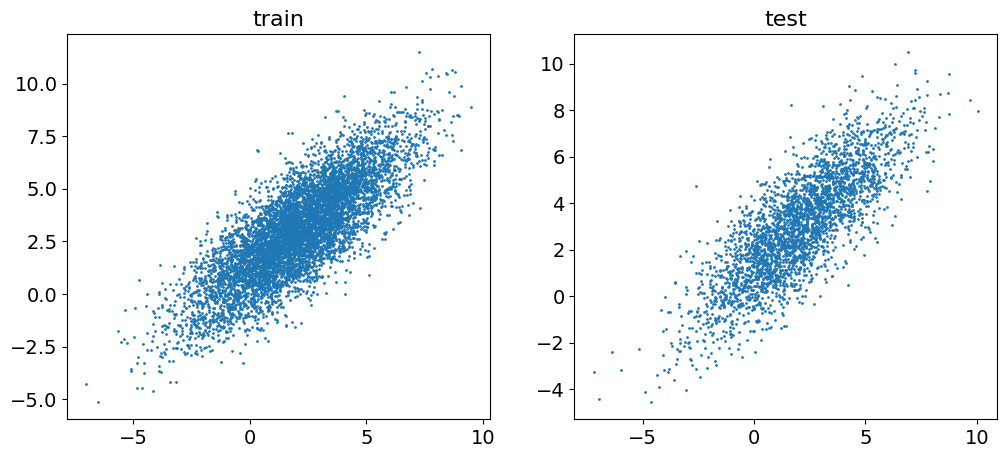

elbo_loss: 4.0065
recon_loss: 2.8811
kl_loss: 1.1255


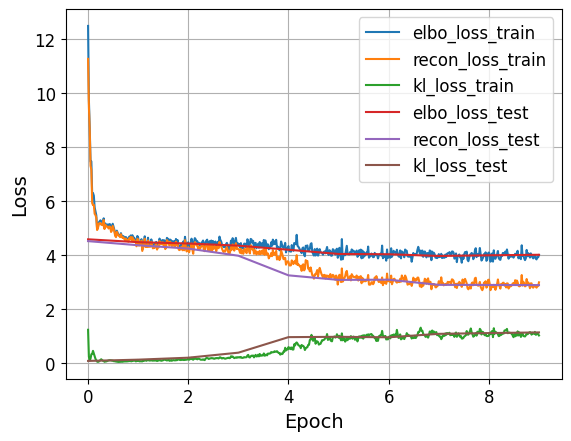

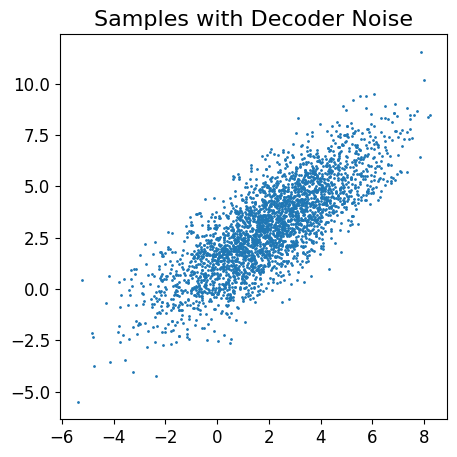

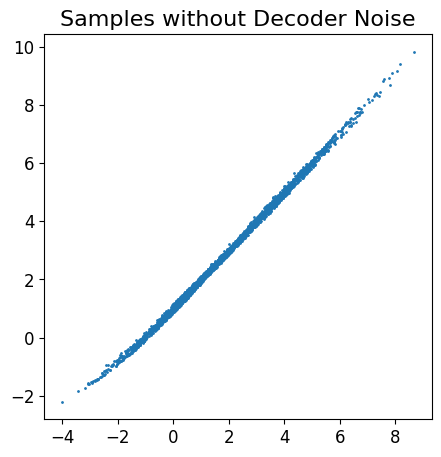

In [15]:
train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES)
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

## Univariate Gaussian Distribution

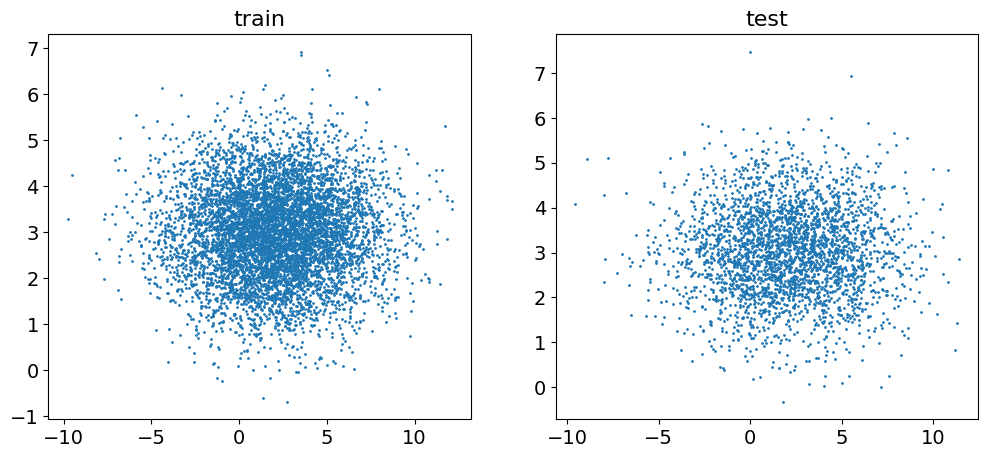

elbo_loss: 3.9524
recon_loss: 3.9415
kl_loss: 0.0108


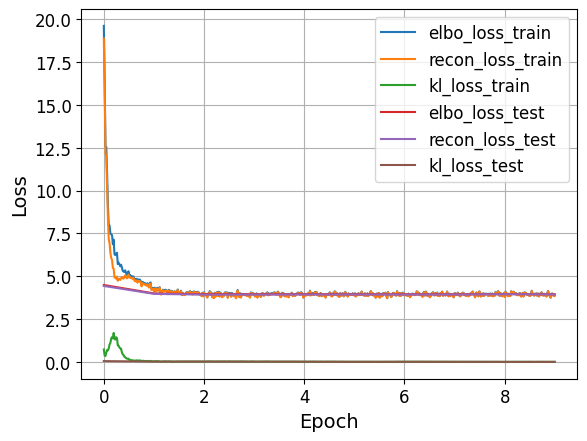

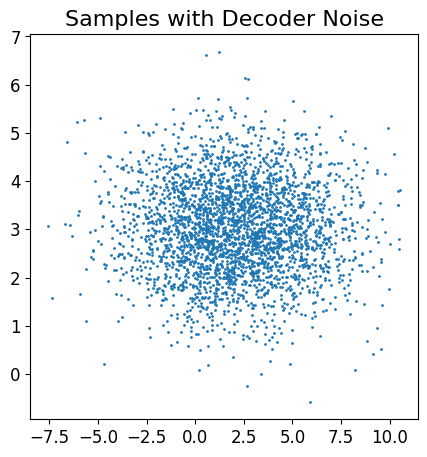

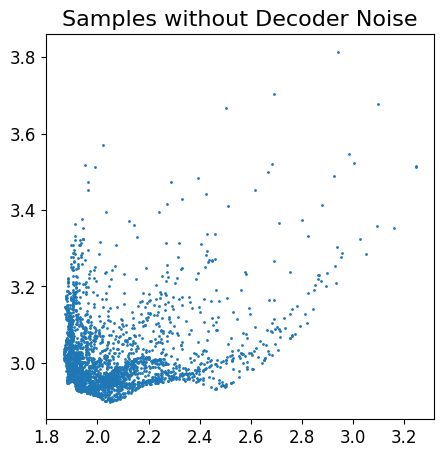

In [16]:
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 128  # any adequate value
EPOCHS = 10  # < 10
LR = 0.001  # < 1e-2

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)

# Posterior collapse

We model the following distribution:
$$
    p_\theta (x) = \int p_\theta (x, z) dz = \int p_\theta(x | z) p(z) dz
$$

Minimizing the following loss (ELBO):
$$
    L(\theta, \varphi) =
        \mathbb{E}_{q_{\varphi}(z | x)} \log p_{\theta} (x | z) -
        KL\{q_{\varphi} (z | x) || q(z)\}
$$

Let decoder $p_\theta(x | z)$ be so "powerful", that $p_\theta(x) \in \mathcal{P} = \{p_\theta(x | z) | \theta, z\}$.

Then
$$
    L(\theta, \varphi) =
        \log p_{\theta} (x) -
        KL\{q_{\varphi} (z | x) || q(z)\}.
$$
Hence, $q_{\hat{\varphi}} (z | x) = q(z)$.

So latents $z$ contain no useful information about $x$.

There are two techniques to alleviate this effect.

1. KL-annealing
$$
    L(\varphi, \theta, \beta) = 
        \mathbb{E}_{q_{\varphi}(z | x)} \log p_{\theta} (x | z) -
        \beta \cdot KL\{q_{\varphi} (z | x) || q(z)\}
$$

2. Free-bits
$$
    L(\varphi, \theta, \lambda) = 
        \mathbb{E}_{q_{\varphi}(z | x)} \log p_{\theta} (x | z) -
        max(\lambda, KL\{q_{\varphi} (z | x) || q(z)\})
$$

## Univariate Gassian Distribution (free-bits)

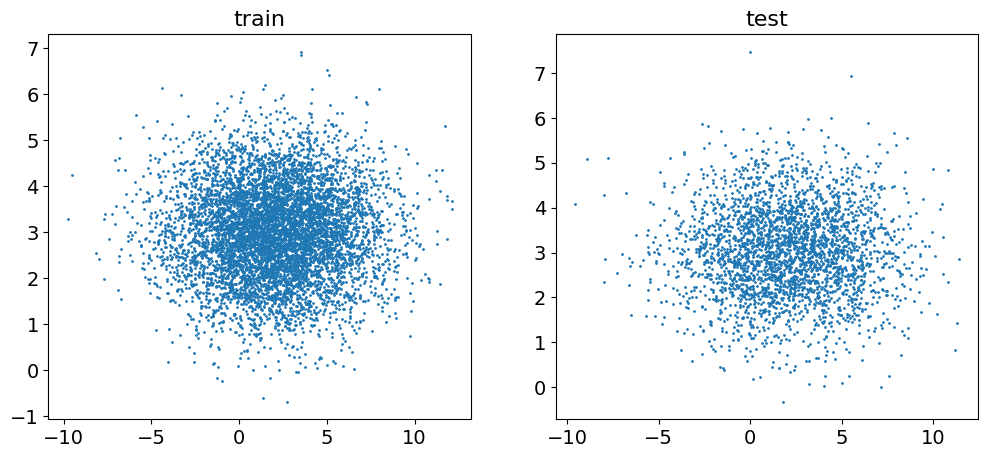

elbo_loss: 3.9703
recon_loss: 2.2144
kl_loss: 1.7559


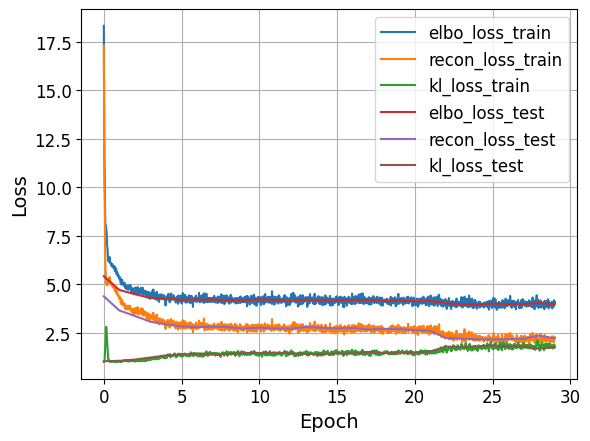

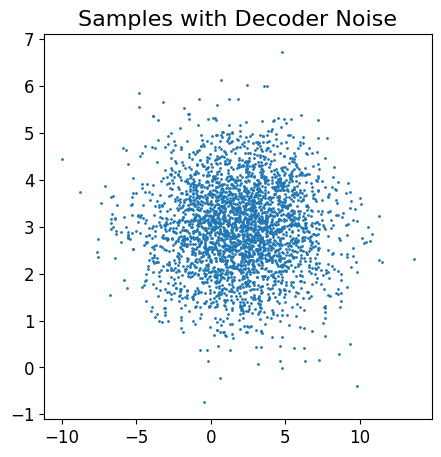

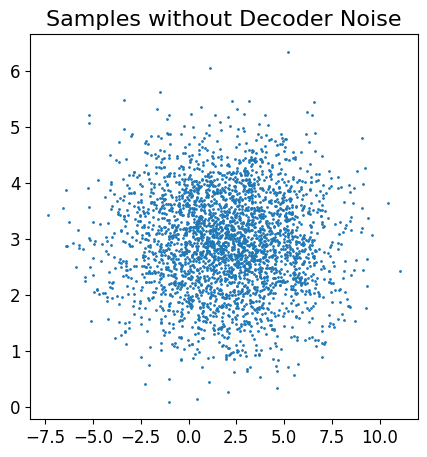

In [17]:
ENC_HIDDEN_SIZES = [128, 128]
DEC_HIDDEN_SIZES = [128, 128]
BATCH_SIZE = 128
EPOCHS = 30
LR = 0.001

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES, free_bits=0.5).cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR, use_cuda=USE_CUDA)